# Federal Election Committee Data

Performing exploratory data analysis on the FEC data of money exchanged during the 2016 election. I will be looking at the data found at the [FEC website](http://classic.fec.gov/finance/disclosure/ftpdet.shtml#a2015_2016). The specific files that I downloaded were the Committee Master file, Candidate Master file, and Contributions by Individuals. The Contributions by Individuals file is very large and therefore I will be looking specifically at contributions from individuals in Berkeley, CA. 

I have two goals for this project. 

- Answer questions by computing descriptive statistics on the data
- Conduct a hypothesis test

I will complete almost all of this project using SQL. A small portion will rely on the use of pandas dataframes in Python.

In [133]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import sqlalchemy

## Postgres

I am hosting the data through Heroku Postgres. I loaded the data into the Heroku Database and can connect to it using the URI that I was provided. For security reasons, I am not posting my personal Heroku URI, but this will not affect the notebook or what is displayed.

In [22]:
my_URI = 'postgres://uri'
%reload_ext sql
%sql $my_URI
engine = sqlalchemy.create_engine(my_URI)
connection = engine.connect()

## Table Descriptions

Here is a list of the tables in the database.  Each table links to the documentation on the [FEC page](http://www.fec.gov/finance/disclosure/ftpdet.shtml) for the dataset.

- [`cand`](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryCandidateMaster.shtml): Candidates table. Contains names and party affiliation.
- [`comm`](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryCommitteeMaster.shtml): Committees table. Contains committee names and types.
- [`indiv_sample`](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryContributionsbyIndividuals.shtml): Sample of individual contributions from Berkeley.
- [`indiv_sample_top`](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryContributionsbyIndividuals.shtml): Sample of individual contributions from the top contributors at Berkeley.

In [59]:
%sql SELECT * FROM indiv_sample LIMIT 5

5 rows affected.


cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,zip_code,employer,occupation,transaction_dt,transaction_amt,other_id,tran_id,file_num,memo_cd,memo_text,sub_id
C00404525,N,YE,P,201601050300036659,15,IND,"KURZWEIL, JACK",BERKELEY,CA,94703,RETIRED,RETIRED,10062015,500,None,SA01271666597,1043014,None,None,2012820161261113255
C00577130,A,M6,P,201608159022353532,15E,IND,"LENHOFF, BERNIE",BERKELEY,CA,947031658,ARBORICULTURAL SPECIALTIES,MANAGER,05042016,15,C00401224,VPF7BPFVV37,1094141,None,* EARMARKED CONTRIBUTION: SEE BELOW,4081720161312601930
C00193433,N,M8,None,201508149000826883,15,IND,"MURRA, LAURA S MS.",BERKELEY,CA,94708,NONE,NONE,07012015,60,None,4356366,1021594,None,None,4081720151248947285
C00042366,A,30G,P,201612080200695092,15E,IND,"FISHER, BRIGITTE",BERKELEY,CA,947052825,NONE,NOT EMPLOYED,11042016,50,C00401224,SA011717509239506,1139429,None,* EARMARKED CONTRIBUTION: SEE BELOW,1060820170035181652
C00577130,A,M3,P,201606169018323111,15E,IND,"RISING, TODD",BERKELEY,CA,947021513,"ADAM BEYDA, PSY.D",PSYCHOLOGICAL ASSISTANT,02212016,27,C00401224,VPF7BKE39K0,1077916,None,* EARMARKED CONTRIBUTION: SEE BELOW,4063020161300916281


In [25]:
query = '''
SELECT cand_id, cand_name
FROM cand
WHERE cand_pty_affiliation = 'DEM'
LIMIT 5
'''

%sql $query

5 rows affected.


cand_id,cand_name
H0CA03078,"BERA, AMERISH"
H0CA15148,"HONDA, MIKE"
H2AZ09019,"SINEMA, KYRSTEN"
H2CA00120,"BROWNLEY, JULIA"
H2CA06259,"HUFFMAN, JARED"


## Large Donors

I am interesting in looking at the individuals who donated large sums of money. In this query, I am using COUNT to see how many individuals donated over $3000 in a single transaction. 

In [31]:
query = """
SELECT COUNT(*)
FROM indiv_sample
WHERE transaction_amt > 3000
"""
%sql $query

1 rows affected.


count
4


It is interesting to find that there are only 4 individuals who donated a sum of money over $3000 in a single transaction. Since there is a small number of individuals I can make a table that shows all of these individuals.

In [32]:
query = """
SELECT 
    cmte_id AS committee_id,
    name AS name,
    transaction_amt AS transaction_amt
FROM indiv_sample
WHERE transaction_amt > 3000
ORDER BY transaction_amt DESC, name;
"""

%sql $query

4 rows affected.


committee_id,name,transaction_amt
C00586537,"GUND, LOUISE LAIDLAW",25000
C00000935,"FIDDLER, JERRY",10000
C00586537,"LAPPEN, DAVID",5000
C00401224,"LUEVANO, ROSA",5000


Single transactions can be misleading. To best understand individual donors it will be far more insightful to aggregate the total sum of donations. 

In [30]:
query = '''
SELECT 
    name AS name,
    SUM(transaction_amt) AS total_transaction_amt 
FROM indiv_sample 
GROUP BY name
ORDER BY total_transaction_amt DESC, name
LIMIT 20;
'''
%sql $query

20 rows affected.


name,total_transaction_amt
"GUND, LOUISE LAIDLAW",25000
"FIDDLER, JERRY",10000
"SHENKER, SCOTT",8000
"BERLEKAMP, ELWYN",5550
"ABRAMS, DENISE",5400
"LAPPEN, DAVID",5000
"LUEVANO, ROSA",5000
"BERNHARDT, ANTHONY",3200
"HUFF, GERALD",3200
"BIRD, KAREN",2700


## Donors by Occupation

Another interesting statistic is to look at is the distribution of contributors by occupation.

In [35]:
query = '''
SELECT 
    COUNT(DISTINCT occupation)
FROM indiv_sample 
'''
%sql $query

1 rows affected.


count
407


There are 407 unique occupations that donated to candidates. With this in mind, I can now create a query to look at the highest represented occupations. 

In [49]:
query = '''
SELECT 
    occupation, 
    COUNT(transaction_amt) AS count
FROM indiv_sample
GROUP BY occupation
ORDER BY count DESC, occupation
LIMIT 20
'''
%sql $query

20 rows affected.


occupation,count
NOT EMPLOYED,373
RETIRED,306
None,70
PROFESSOR,58
ATTORNEY,56
NONE,33
SCIENTIST,30
ENGINEER,20
PHONE CLERK,20
RETIRED TEACHER,20


I can also look at the average donated amount per occupation. It is important to add a column with the number of transactions. From the table below, it is easy to see that all of the highest occupations only had one yet substantial donation.

In [52]:
query = '''
SELECT 
    occupation AS occupation, 
    ROUND(AVG(transaction_amt),2) AS avg_amount,
    COUNT(transaction_amt) AS count
FROM indiv_sample 
GROUP BY occupation
ORDER BY avg_amount DESC, occupation
LIMIT 10
'''
%sql $query

10 rows affected.


occupation,avg_amount,count
LOUISE GUND FOUNDATION,25000.00,1
INVESTOR/BOARD MEMBER,10000.00,1
MARRIAGE & FAMILY THERAPIST,5000.00,1
CHAIRMAN,2700.00,1
INVESTMENT MANAGEMENT,2700.00,1
LIVE THEATRE PRODUCER,2700.00,1
AIDS CASE MANAGER,2500.00,1
WEALTH MANAGER,1700.00,1
INVESTOR,1485.00,2
ACCOUNTANT,1475.00,2


Since the previous statistic was not particularly informative I will have to revise my query and add a constraint of more than 10 transactions. 

In [141]:
query = '''
SELECT 
    occupation AS occupation, 
    avg_amount AS amount,
    count AS count
FROM
    (SELECT 
    occupation AS occupation, 
    ROUND(AVG(transaction_amt),2) AS avg_amount,
    COUNT(transaction_amt) AS count
    FROM indiv_sample 
    GROUP BY occupation
    ORDER BY avg_amount DESC, occupation)
    AS results
WHERE count > 10
ORDER BY amount DESC
LIMIT 10
'''
%sql $query

10 rows affected.


occupation,amount,count
ATTORNEY,423.95,56
SOFTWARE ENGINEER,371.00,13
CONSULTANT,343.08,12
STUDENT,317.55,11
SCIENTIST,298.37,30
ENGINEER,228.50,20
ARTIST,216.26,19
PHYSICIAN,193.83,18
RETIRED,143.74,306
UNEMPLOYED,140.83,18


This is a better statistic, yet, since each individual can make multiple transactions it is still not as informative as I would like it. To achieve the average for a given occupation, I need to take the average of each individual's total amount. 

In [55]:
query = '''
SELECT 
    occupation AS occupation,
    name AS name,
    SUM(transaction_amt) AS total_amount
FROM indiv_sample 
GROUP BY name, occupation
ORDER BY total_amount DESC, name
LIMIT 10
'''
%sql $query

10 rows affected.


occupation,name,total_amount
LOUISE GUND FOUNDATION,"GUND, LOUISE LAIDLAW",25000
INVESTOR/BOARD MEMBER,"FIDDLER, JERRY",10000
SCIENTIST,"SHENKER, SCOTT",8000
RETIRED,"BERLEKAMP, ELWYN",5550
ATTORNEY,"ABRAMS, DENISE",5400
MARRIAGE & FAMILY THERAPIST,"LAPPEN, DAVID",5000
NOT EMPLOYED,"LUEVANO, ROSA",5000
RETIRED,"BERNHARDT, ANTHONY",3200
SOFTWARE ENGINEER,"HUFF, GERALD",3200
ACCOUNTANT,"BIRD, KAREN",2700


After computing the total amount I can compute the average total_amount for each occupation type. To filter out the occupations that have small counts, the query will constrain the number of contributors in that occupation to those greater than 5.

In [57]:
query = '''
SELECT *
    FROM
    (SELECT 
        occupation AS occupation, 
        ROUND(AVG(total_amount),2) AS amount,
        COUNT(occupation) AS count
    FROM
        (SELECT 
        occupation AS occupation,
        name AS name,
        SUM(transaction_amt) AS total_amount
        FROM indiv_sample 
        GROUP BY name, occupation
        ORDER BY total_amount DESC, name)
        AS results
    GROUP BY occupation
    ORDER BY amount DESC)
    AS result2
WHERE count > 5
LIMIT 10

'''
%sql $query

10 rows affected.


occupation,amount,count
SCIENTIST,1118.88,8
ATTORNEY,593.53,40
SOFTWARE ENGINEER,535.89,9
CONSULTANT,374.27,11
STUDENT,349.30,10
NOT-EMPLOYED,331.67,9
ARTIST,273.93,15
PHYSICIAN,268.38,13
ENGINEER,253.89,18
PROFESSOR,240.06,32


## Committees

The comm table provides information about the various committees that individuals donate money to. The way the data is formatted only references the committee id (cmte_id) in the indiv_sample table. Therefore, I will need to perform a series of JOINs to get the more meaningful committee name (cmte_nm).

In [60]:
%sql select * from comm limit 5

5 rows affected.


cmte_id,cmte_nm,tres_nm,cmte_st1,cmte_st2,cmte_city,cmte_st,cmte_zip,cmte_dsgn,cmte_tp,cmte_pty_affiliation,cmte_filing_freq,org_tp,connected_org_nm,cand_id
C00000729,AMERICAN DENTAL ASSOCIATION POLITICAL ACTION COMMITTEE,"HARRISON, THOMAS C. DR","1111 14TH STREET, NW",SUITE 1100,WASHINGTON,DC,20005,B,Q,UNK,M,M,AMERICAN DENTAL ASSOCIATION,None
C00000935,DCCC,"WARD, KELLY C.","430 SOUTH CAPITOL STREET, SE",2ND FLOOR,WASHINGTON,DC,200034024,U,Y,DEM,M,None,None,None
C00001016,CARPENTERS LEGISLATIVE IMPROVEMENT COMMITTEE UNITED BROTHERHOOD OF CARPENTERS AND JOINERS,"SILINS, ANDRIS","101 CONSTIUTION AVENUE, NW",10TH FLOOR WEST,WASHINGTON,DC,20001,B,Q,NNE,M,L,UNITED BROTHERHOOD OF CARPENTERS AND JOINERS OF AMERICA,None
C00003418,REPUBLICAN NATIONAL COMMITTEE,"PARKER, ANTHONY W MR",310 FIRST STREET SE,None,WASHINGTON,DC,20003,U,Y,REP,M,None,HOUSE MAJORITY TRUST,None
C00009936,AMERICAN FEDERATION OF GOVT. EMPL. POLITICAL ACTION COMMITTEE,"GAGE, JOHN MR.","80 F STREET, NW",None,WASHINGTON,DC,20001,B,Q,UNK,M,L,AMERICAN FEDERATION OF GOV'T EMPLOYEES,None


Using just the indiv_sample table I can SUM and GROUP BY to get the committees with the highest amount of money donated. However, this does not say anything about the specifics of the committee, which has its information stored in the comm table. 

In [67]:
query ='''
SELECT
    cmte_id AS committee_id,
    SUM(transaction_amt) AS total_amount,
    COUNT(cmte_id) AS count
FROM indiv_sample
GROUP BY committee_id
ORDER BY count DESC
LIMIT 5
'''
%sql $query

5 rows affected.


committee_id,total_amount,count
C00401224,66228,799
C00575795,38002,252
C00577130,19920,239
C00000935,26040,153
C00042366,7271,71


Expanding upon the previous query and crosslisting with the comm table will provide a table that includes how much monet and how many total donations each committee recieved. From here I will take the top 10 with highest total donations to look at.  

In [83]:
query = '''
WITH cmte_count AS
(
SELECT
    cmte_id AS committee_id,
    SUM(transaction_amt) AS total_amount,
    COUNT(cmte_id) AS count
FROM indiv_sample
GROUP BY committee_id
)
SELECT 
    cmte_nm AS committee_name, 
    cmte_pty_affiliation AS party_affiliation,
    cmte_city AS city,
    cmte_st AS state,
    i.total_amount AS total_amount,
    i.count AS count
FROM comm c JOIN cmte_count i ON committee_id = cmte_id
GROUP BY  c.cmte_nm, c.cmte_pty_affiliation, c.cmte_city, c.cmte_st, i.total_amount, i.count
ORDER BY count DESC, committee_name
LIMIT 10
'''
%sql $query

10 rows affected.


committee_name,party_affiliation,city,state,total_amount,count
ACTBLUE,None,SOMERVILLE,MA,66228,799
HILLARY FOR AMERICA,DEM,NEW YORK,NY,38002,252
BERNIE 2016,DEM,BURLINGTON,VT,19920,239
DCCC,DEM,WASHINGTON,DC,26040,153
DSCC,DEM,WASHINGTON,DC,7271,71
END CITIZENS UNITED,None,WASHINGTON,DC,1129,47
HILLARY VICTORY FUND,None,NEW YORK,NY,44163,45
MOVEON.ORG POLITICAL ACTION,None,WASHINGTON,DC,2836,37
CATHERINE CORTEZ MASTO FOR SENATE,DEM,LAS VEGAS,NV,6878,27
EMILY'S LIST,None,WASHINGTON,DC,7988,26


Looking at the table, 5 out of the 10 top committee's are affiliated with the democratic party (DEM). I want to see from all committees that appear in indiv_sample, meaning recieved a donation from an individual in Berkeley, CA, what is the distribution of party affiliation.

In [84]:
query = '''
WITH cmte AS
(
  SELECT 
      cmte_id AS cmte_id
  FROM indiv_sample 
  GROUP BY cmte_id
)
SELECT 
    cmte_pty_affiliation AS party_affiliation,
    COUNT(*) AS count
FROM comm c JOIN cmte i on c.cmte_id = i.cmte_id
GROUP BY party_affiliation
ORDER BY count DESC, party_affiliation
LIMIT 10
'''
%sql $query

6 rows affected.


party_affiliation,count
DEM,58
None,44
REP,8
UNK,4
NNE,2
GRE,1


## Hypothesis Testing

**Is there a difference in the proportion of donations made by small donors (under \$200) in Berkeley to Hillary Clinton's and Bernie Sanders' campaigns?**

To formulate a null hypothesis, it is important to consider the how the data is generated. I know that the sample was taken at random from the collection of all donations from Berkeley donors. I can argue that Clinton attracts small donors at the same rate as Sanders. Then, given the proportion of donors in the combined sample of Clinton and Sanders donors, it is just by chance that the proportion for Sanders and the proportion for Clinton are not equal. 

**Permutation Test:**  In a permuation test, or randomization test, I will mix up the small and large donors, and then record the number of small donors to Clinton and to Sanders. After many permutations, it then becomes easier to examine the distribution of differences to see how likely it was to have observed our sample's difference. 

**Formal Hypothesis:**

**$H_o$:** Clinton and Sanders attract the same proportion of small donors. Any observed difference in our sample is simply due to chance variation.

**$H_A$:**  The difference is real. 


I have taken a simple random sample of 2000 rows of the original FEC data for individual contributions that only include contributions from Berkeley. This sample is stored in the table `indiv_sample`.

The individual contributions of donors are linked to committees rather than candidates directly. Hillary's primary committee was called `HILLARY FOR AMERICA` and Bernie's was `BERNIE 2016`.

In [88]:
query = """
CREATE OR REPLACE VIEW contribs AS
SELECT name, transaction_amt, c.cmte_nm
FROM indiv_sample i JOIN comm c ON c.cmte_id = i.cmte_id
WHERE c.cmte_nm = 'HILLARY FOR AMERICA' OR c.cmte_nm = 'BERNIE 2016'
ORDER BY transaction_amt DESC, name
"""
%sql DROP VIEW IF EXISTS contribs
%sql $query
%sql SELECT * FROM contribs LIMIT 5

Done.
Done.
5 rows affected.


name,transaction_amt,cmte_nm
"HAHN, SOPHIE",2700,HILLARY FOR AMERICA
"JOSEPH, DAVID",2700,HILLARY FOR AMERICA
"LITTMANN, NICOLE",2700,BERNIE 2016
"LOGAN, JONATHAN",2700,BERNIE 2016
"REINIS, JONATHAN ROY",2700,HILLARY FOR AMERICA


I am going to create a table grouping the tranactions according to the candidate. Then I will create a column with the number of donations classified as small (under $200) and a column with the total number of donations. 

From here I will be able to calculate a statistic as follows:

$$ \frac {\textrm{total donations under \$200 to Hillary}} {\textrm{total donations to Hillary}} - 
    \frac {\textrm{total donations under \$200 to Bernie}} {\textrm{total donations to Bernie}}. 
$$

The calculation of the stat will be completed using pandas dataframe and python.

In [130]:
query = '''
WITH marked AS (
    SELECT *,
    transaction_amt <= 200 AS small 
    FROM contribs
)
SELECT cmte_nm,
    COUNT(CASE WHEN small THEN 1 END) AS small,
    COUNT(*) AS total
FROM marked
GROUP BY cmte_nm
ORDER BY cmte_nm
'''

df = pd.DataFrame(connection.execute(query).fetchall(), columns=['cmte_nm', 'small', 'total'])

# Fill this in with the observed test statistic
observed_stat = (df.iloc[1]['small']/df.iloc[1]['total']) - (df.iloc[0]['small']/df.iloc[0]['total'])

%sql $query

2 rows affected.


cmte_nm,small,total
BERNIE 2016,212,239
HILLARY FOR AMERICA,225,252


In [136]:
observed_stat

0.0058278541542140516

Even though the difference is quite small, this difference could still be considered large relative to the standard error of the statistic. 

## Bootstrapping

1. Shuffle the observed values between the two samples. In this case, shuffle the contributions between Hillary and Bernie. 
2. Recompute the test statistic on the shuffled sample.
3. Repeat.


In [121]:
sample = '''
DROP VIEW IF EXISTS sample CASCADE;

CREATE OR REPLACE VIEW sample AS 
    SELECT row_number() over () AS row_id, transaction_amt, cmte_nm
    FROM contribs;

SELECT * FROM sample LIMIT 10
'''

%sql $sample

Done.
Done.
10 rows affected.


row_id,transaction_amt,cmte_nm
1,2700,HILLARY FOR AMERICA
2,2700,HILLARY FOR AMERICA
3,2700,BERNIE 2016
4,2700,BERNIE 2016
5,2700,HILLARY FOR AMERICA
6,2700,HILLARY FOR AMERICA
7,2700,HILLARY FOR AMERICA
8,2700,HILLARY FOR AMERICA
9,2500,HILLARY FOR AMERICA
10,1000,HILLARY FOR AMERICA


My sample table contains 491 rows. I need to create a table called design that holds the random shuffles of this data. I will be performing 1000 reshuffles so therefore my new table will contain 491,000 rows, each with a trial_id and a row_id. 

- trial_id: the number of the trial from 1 to 1000
- row_id: row number shuffled, between 1 and 491

In [124]:
n_rows = 491
n_trials = 1000

query = """
CREATE VIEW design AS
SELECT 
    generate_series(1, $n_trials) AS trial_id,
    generate_series(1, $n_rows) AS row_id 
ORDER BY trial_id, RANDOM()
LIMIT 491000
"""
import string
query = string.Template(query).substitute(locals())

seed = 0.42
%sql drop view if exists design cascade
%sql SET SEED TO $seed
%sql $query
%sql select * from design limit 10

Done.
Done.
Done.
10 rows affected.


trial_id,row_id
1,483
1,224
1,269
1,121
1,99
1,220
1,377
1,25
1,460
1,409


I am now able to construct the table with the shuffled transaction amounts (transaction_amt) along with the unshuffled committee names. Essentially, I am constructing a table with shuffled transaction values between the committees.

In [125]:
query = '''
CREATE VIEW joined as
WITH num AS (
    SELECT MOD(row_number() over () - 1, $n_rows) + 1 AS row_in_group, *
    FROM design
)
SELECT n.trial_id, s1.transaction_amt, s2.cmte_nm
    FROM sample s1, sample s2, num n 
    WHERE n.row_id = s1.row_id
    AND s2.row_id = n.row_in_group
'''

query = string.Template(query).substitute(locals())
%sql drop view if exists joined cascade
%sql SET SEED TO $seed
%sql $query
%sql select * from joined limit 10

Done.
Done.
Done.
10 rows affected.


trial_id,transaction_amt,cmte_nm
1,3,HILLARY FOR AMERICA
1,37,HILLARY FOR AMERICA
1,25,BERNIE 2016
1,100,BERNIE 2016
1,100,HILLARY FOR AMERICA
1,38,HILLARY FOR AMERICA
1,15,HILLARY FOR AMERICA
1,270,HILLARY FOR AMERICA
1,5,HILLARY FOR AMERICA
1,10,HILLARY FOR AMERICA


For the 1000 trials, I am then able to calculate the number of small donors by candidate. This results in 2000 rows, 2 per trial. 

I will then calculate the observed statistic, as I did previously, for each of the 1000 trials. 

In [129]:
query = '''
WITH marked AS (
    SELECT  *,
        transaction_amt <= 200 AS small 
    FROM joined
)
SELECT trial_id, cmte_nm,
    count(CASE WHEN small THEN 1 END) AS small,
    COUNT(*) AS total
FROM marked
GROUP BY trial_id, cmte_nm
ORDER BY trial_id, cmte_nm
'''

query = string.Template(query).substitute(locals())
%sql SET SEED TO $seed
%sql $query

df = pd.DataFrame(connection.execute(query).fetchall(),
                      columns=['trial_id', 'cmte_nm', 'small', 'total'])

trials = []
i = 1
while i < len(df):
    trials.append((df.iloc[i]['small']/df.iloc[i]['total']) - (df.iloc[i-1]['small']/df.iloc[i-1]['total']))
    i += 2
trials = pd.DataFrame(trials, columns=['stats'])
trials[0:10]

Done.
2000 rows affected.


,stats
0,-0.002325
1,0.005828
2,-0.010477
3,-0.043086
4,0.005828
5,0.013980
6,-0.018629
7,-0.002325
8,0.022133
9,0.005828


Using Seaborn's displot tool, I can plot the observed statistic on each of the 1000 trials and compare them with the actual statistic, represeted by the 2 vertical red lines. 

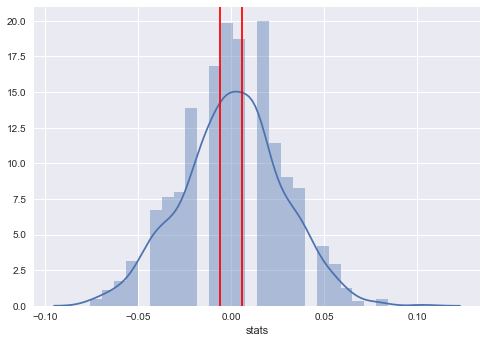

In [137]:
sns.distplot(trials['stats'])
plt.axvline(x=observed_stat, color='r')
plt.axvline(x= -observed_stat, color='r')
plt.show()

To compute the $p$-value based on the test statistics generated through the shuffled samples.  I need to find the proportion of the 1000 test statistics that are at least as large in absolute value as the observed statistic.

In [140]:
stats = [abs(i) >= observed_stat for i in trials['stats']]
p_value = 1 - (sum(stats)/len(trials['stats']))
p_value

0.127

Based on the p-value, I cannot reject the null hypothesis using a cutoff of 5%. The observed variation is large and therefore I cannot assume that the variation is due to chance. Rejecting the null hypothesis concludes that the proportion of small donors for Hillary Clinton and Bernie Sanders is not equal.